# Exploring Pitch, ZCR, and MFCC Features for Deceptive Story Classification

# 1 Author

**Student Name**: Charles Man

**Student ID**: 240758440



# 2 Problem formulation

The machine learning problem that I want to solve is predicting whether a narrated story is true or not. Specifically, I will build a machine learning model that takes as an input an audio recording of 30 seconds of duration and predicts whether the story being narrated is true or deceptive. This problem is unique because it combines elements of speech processing, behavioral analysis, and machine learning to tackle the complex and nuanced task of deception detection. This task relies on features extracted from audio recordings, such as pitch, zero-crossing rate, and MFCCs, which capture subtle vocal cues that may indicate deceptive behavior. Additionally, the temporal and psychological dynamics of storytelling make this problem challenging and different from conventional classification tasks, as it requires models to discern patterns that are often subconscious and dependent on context. It is also important to note that the audio recordings are in different languages, which is a factor that should be taken into account.

# 3 Methodology

**Training Task**

1. Feature Selection

 * Pitch - mean: average pitch
 * Pitch - standard deviation: pitch variability
 * Mel-frequency cepstral coefficients (MFCCs): spectral envelope of audio
 * Zero-crossing rate: frequency of  sign changes, correlating with signal texture

2. Data Preparation

 * Slice each audio file into four 30-second segments.
 * Split the dataset into training (80%) and testing (20%) sets, ensuring that all segments of a file go into the same split.

3. Training Process

 * Extract the selected features from each audio file using Librosa.
 * Standardize the features using StandardScaler to ensure feature comparability.
 * Use logistic regression and train the model on the training set using the features as predictors and the binary labels (true_story/deceptive_story) as targets.

**Validation Task**

* Perform 5-fold cross-validation on the training set:
 * Split the training data into five subsets, train on four subsets, and validate on the fifth.
 * Rotate the validation subset across folds to ensure every sample is used for both training and validation.

**Performance Metrics**

* 5-fold cross-validation accuracy
* Confusion matrix
* Classification report

# 4 Implemented ML prediction pipelines

**Overview**

* Input: raw audio recordings (30 sec long) in .wav format
* Output: binary classification prediction (true_story/deceptive_story) for each segment
* Pipeline stages:
 1. Transformation: feature extraction and preprocessing of raw audio data
 2. Model: logistic regression model training and evaluation

## 4.1 Transformation stage

The transformation stage involves extracting relevant features from the raw audio recordings. These features are crucial for the ML model to identify patterns associated with true and deceptive stories.

**Input**

* Raw audio recordings (30 sec each) in .wav format

**Process**

1. Feature Extraction (Librosa)

 * Pitch - mean: the average pitch of the audio signal over the 30-sec duration, which can provide insight into the speaker's tone.
 * Pitch - standard deviation: the variation in pitch, which can help distinguish emotional and vocal variations between true and false narratives.
 * Mel-frequency cepstral coefficients (MFCCs): the spectral envelope of audio, capturing key features of speech that are critical for distinguishing phonetic and speaker characteristics.
 * Zero-crossing rate (ZCR): the rate at which the audio signal changes polarity, providing a sense of speech texture and rhythm.

2. Standardization

 * The data will be standardized using StandardScaler from scikit-learn to ensure that all features are on a comparable scale, as logistic regression is sensitive to feature scaling.

**Output**

* Feature matrix consisting of the four features for each audio sample.

**Why this transformation?**

This transformation extracts features that capture key characteristics of speech, such as pitch variability, rhythm, and spectral properties, which are essential for distinguishing between true and deceptive narratives. Standardizing the features ensures that all inputs contribute equally to the model, improving its performance and interpretability.

## 4.2 Model stage

In this stage, the ML model is trained and evaluated. Given the problem's binary classification nature, logistic regression is chosen as the model for predicting whether a story is true or deceptive.

**Input**

* Feature matrix containing the four standardized features for each sample
* Binary labels (true_story/deceptive_story) for each story

**Process**

1. Model Training

 * Logistic regression will be used for training the model on the training dataset. The model will learn the relationship between the extracted features and the target variable (true_story/deceptive_story).

2. Model Evaluation

 * The model's performance will be evaluated on the test set, with the help of 5-fold cross-validation.

**Output**

* Trained logistic regression model, capable of predicting whether a narrated story is true or deceptive based on the input features

**Why logistic regression?**

* Simple yet effective model for binary classification tasks
* Interpretable, allowing for analysis of the relationship between the input features and the predicted outcome
* Works well with standardized numerical features

# 5 Dataset

**Dataset Preparation**

1. Dataset Loading

  * Import libraries.
  * Download and load the MLEnd Deception Dataset using the `mlend` library.

2. Metadata Extraction

 * Metadata is uploaded from a CSV file containing language and story type information.
 * Features (`X_paths`) consist of paths to .wav audio files, while labels (`Y`) denote their corresponding classes (true_story or deceptive_story).

3. File Path Handling

 * Retrieve the paths of all .wav files for further audio processing and visualization.

4. Train-Test Splitting

 * Split the data into training (80%) and testing (20%) sets using `train_test_split`.

5. Segmentation

 * Create a segmentation function.
 * Slice each audio file in both datasets into four 30-second segments.

In [1]:
# 1. Dataset Loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

!pip install mlend==1.0.0.4

import mlend
from mlend import download_deception_small, deception_small_load

datadir = download_deception_small(save_to='MLEnd', subset={}, verbose=1, overwrite=False)
TrainSet, TestSet, MAPs = deception_small_load(datadir_main=datadir, train_test_split=None, verbose=1, encode_labels=True)

# 2. Metadata Extraction
metadata = pd.read_csv('MLEnd/deception/MLEndDD_story_attributes_small.csv').set_index('filename')
metadata['label'] = metadata['Story_type'].map({'true_story': 0, 'deceptive_story': 1})

# 3. File Path Handling
path = 'MLEnd/deception/MLEndDD_stories_small/*.wav'
files = glob.glob(path)

# 4. Train-Test Splitting
file_names = [file.split('/')[-1] for file in files]
train_files, test_files = train_test_split(file_names, test_size=0.3, random_state=42)

# 5. Segmentation
def segment(files, metadata, segment_length=30, sr=8000, num_segments_per_file=2):
    data = []
    labels = []

    for file in tqdm(files, desc="Segmenting and Normalizing Files"):
        x, fs = librosa.load(f'MLEnd/deception/MLEndDD_stories_small/{file}', sr=sr)
        total_samples = len(x)
        segment_samples = segment_length * sr

        # Split into segments
        segments = [
            x[i:i+segment_samples]
            for i in range(0, total_samples, segment_samples)
            if len(x[i:i+segment_samples]) == segment_samples
        ]

        # Randomly sample segments if there are more than the required number
        if len(segments) > num_segments_per_file:
            segments = random.sample(segments, num_segments_per_file)

        # If there are fewer segments than required, add zeroed segments
        while len(segments) < num_segments_per_file:
            segments.append(np.zeros(segment_samples))

        # Get the label for this file from the metadata
        label = metadata.loc[file]['label']

        # Append the segments and corresponding label
        data.extend(segments)
        # Assign label to each segment
        labels.extend([label] * len(segments))

    return data, labels

X_train, Y_train = segment(train_files, metadata, segment_length=30, sr=22050, num_segments_per_file=2)
X_test, Y_test = segment(test_files, metadata, segment_length=30, sr=22050, num_segments_per_file=2)

print(f"\nNumber of training segments: {len(X_train)}")
print(f"Number of testing segments: {len(X_test)}")

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

 77%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓            |100\77|00077.wav

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|100\100|00100.wav
Done!
Total 100 found in MLEnd/deception/MLEndDD_stories_small/


Segmenting and Normalizing Files:   0%|          | 0/70 [00:00<?, ?it/s]<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2Impo


Number of training segments: 140
Number of testing segments: 60


**Dataset Description**

Training Set
* 70% of the dataset.
* Used for model training.

Testing Set
* 30% of the dataset.
* Matches the training set in class proportions.
* Independent evaluation of model performance.

Metadata
* Language, story type, and file paths.
* Enables advanced analysis.

**Exploratory Analysis and Visualizations**

To understand the dataset better, we can explore the class distribution and audio metadata.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: 

          Language       Story_type  label
filename                                  
00001.wav    Hindi  deceptive_story      1
00002.wav  English       true_story      0
00003.wav  English  deceptive_story      1
00004.wav  Bengali  deceptive_story      1
00005.wav  English  deceptive_story      1
...            ...              ...    ...
00096.wav  English  deceptive_story      1
00097.wav  English       true_story      0
00098.wav  English  deceptive_story      1
00099.wav  English       true_story      0
00100.wav  English  deceptive_story      1

[100 rows x 3 columns]

Class Distribution: {'deceptive_story': 50, 'true_story': 50} 



<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


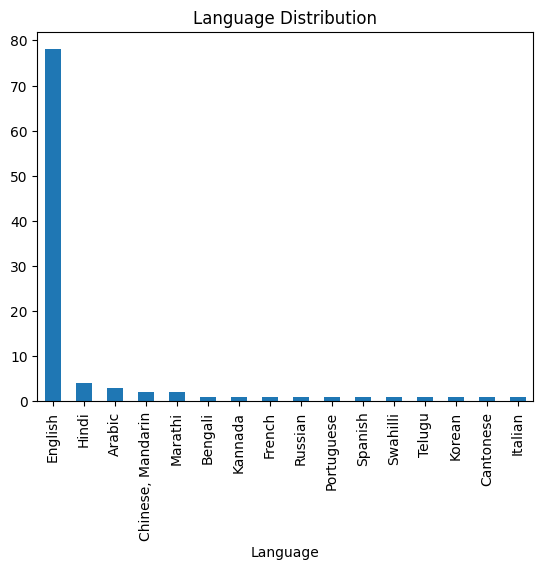

In [2]:
print(metadata)
unique, counts = np.unique(metadata['Story_type'], return_counts=True)
class_distribution = dict(zip(unique, counts))
print("\nClass Distribution:", class_distribution, "\n")
metadata['Language'].value_counts().plot(kind='bar', title='Language Distribution')
plt.show()

**Limitations**

1. Dataset Size

 * The small subset might limit the generalizability of the results. Models trained on this dataset might not scale effectively to larger or more diverse datasets.

2. Audio Quality

 * Variations in audio quality due to factors like background noise or recording device differences could affect model robustness.

# 6 Experiments and results

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

def getPitch(x, fs, winLen=0.02, frame_length=2048, hop_length=512):
    f0, voiced_flag, voiced_probs = librosa.pyin(
        y=x, fmin=80, fmax=450, sr=fs, frame_length=frame_length, hop_length=hop_length
    )
    return f0, voiced_flag

def extract_features(data_segments, labels):
    X = []
    for segment in tqdm(data_segments):
        # Pitch features
        f0, _ = getPitch(segment, fs=8000, winLen=0.02)
        pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0)) < 1 else 0
        pitch_std = np.nanstd(f0) if np.mean(np.isnan(f0)) < 1 else 0

        # Zero-crossing rate
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=segment))

        # MFCCs
        mfccs = np.mean(librosa.feature.mfcc(y=segment, sr=8000, n_mfcc=13), axis=1)

        features = [pitch_mean, pitch_std, zcr] + list(mfccs)
        X.append(features)

    return np.array(X), np.array(labels)

# Extract features
X_train_features, Y_train_labels = extract_features(X_train, Y_train)
X_test_features, Y_test_labels = extract_features(X_test, Y_test)

print(f"\nShape of X_train_features: {X_train_features.shape}")
print(f"Shape of X_test_features: {X_test_features.shape}")

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

# Initialize Logistic Regression model
clf = LogisticRegression(random_state=42, max_iter=1000)

# 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
training_accuracies = []
validation_accuracies = []

print("\nPerforming 5-fold cross-validation...")
for train_index, val_index in kf.split(X_train_scaled, Y_train_labels):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    Y_train_fold, Y_val_fold = Y_train_labels[train_index], Y_train_labels[val_index]

    clf.fit(X_train_fold, Y_train_fold)

    train_accuracy = accuracy_score(Y_train_fold, clf.predict(X_train_fold))
    training_accuracies.append(train_accuracy)

    val_accuracy = accuracy_score(Y_val_fold, clf.predict(X_val_fold))
    validation_accuracies.append(val_accuracy)

mean_train_acc = np.mean(training_accuracies)
mean_val_acc = np.mean(validation_accuracies)

print("\n5-fold Cross-Validation Results:")
print(f"Training Accuracy: {mean_train_acc:.4f} ± {np.std(training_accuracies):.4f}")
print(f"Validation Accuracy: {mean_val_acc:.4f} ± {np.std(validation_accuracies):.4f}")

# Final evaluation on test set
clf.fit(X_train_scaled, Y_train_labels)
Y_pred = clf.predict(X_test_scaled)

print("\nFinal Model Evaluation on Test Set:")
print("\nConfusion Matrix:\n", confusion_matrix(Y_test_labels, Y_pred))
print("\nClassification Report:\n", classification_report(Y_test_labels, Y_pred))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  0%|          | 0/140 [00:00<?, ?it/s]<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen imp


Shape of X_train_features: (140, 16)
Shape of X_test_features: (60, 16)

Performing 5-fold cross-validation...

5-fold Cross-Validation Results:
Training Accuracy: 0.7286 ± 0.0332
Validation Accuracy: 0.6143 ± 0.0525

Final Model Evaluation on Test Set:

Confusion Matrix:
 [[15 19]
 [15 11]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.44      0.47        34
           1       0.37      0.42      0.39        26

    accuracy                           0.43        60
   macro avg       0.43      0.43      0.43        60
weighted avg       0.44      0.43      0.44        60



### Experiment Results Summary

| **Experiment** | **Changes**                     | **Training Acc.** | **Validation Acc.** | **Overall Acc.** | **Precision (0)** | **Recall (0)** | **Precision (1)** | **Recall (1)** | **Confusion Matrix**                                            | **Time (min)** |
|----------------|------------------------------------------|-------------------|---------------------|------------------|-------------------|----------------|-------------------|----------------|------------------------------------------------------------------|----------------|
| **#1**         | Original experiment       | 0.6927            | 0.6514              | 0.67             | 0.69              | 0.59           | 0.65              | 0.74           | [[24 17] <br> [11 32]]                                          | 33m 45s          |
| **#2**         | Optimized `getPitch` with fixed defaults | 0.6600            | 0.6218              | 0.62             | 0.63              | 0.54           | 0.61              | 0.70           | [[22 19] <br> [13 30]]                                          | 19m 25s          |
| **#3**         | Optimized `getPitch`, standardized       | 0.6823            | 0.6425              | 0.67             | 0.69              | 0.59           | 0.65              | 0.74           | [[24 17] <br> [11 32]]                                          | 18m 55s          |
| **#4**         | Downsampled to 8000 Hz                   | 0.7098            | 0.6639              | 0.63             | 0.65              | 0.54           | 0.62              | 0.72           | [[22 19] <br> [12 31]]                                          | 7m 19s           |
| **#5**| Downsampled, split into 4 segments      | 0.6268            | 0.6500              | 0.65             | 0.82              | 0.49           | 0.56              | 0.87           | [[33 35] <br> [7 45]]                                           | 19m 28s          |
| **#6**         | Downsampled, split into 2 segments       | 0.7286            | 0.6143              | 0.43             | 0.50              | 0.44           | 0.37              | 0.42           | [[15 19] <br> [15 11]]                                           | 8m 7s           |

Note: The model shown above is Experiment #6.

Segmentation plays a crucial role in managing long audio files. Experiment #5, with four 30-second segments, performed relatively well in terms of validation accuracy, precision, and recall. In contrast, Experiment #6 (with only two segments) underperformed, indicating that reducing the number of segments may hinder the model's ability to capture temporal patterns in the audio.

In Experiment #4, the training accuracy was 70.98%, and the validation accuracy was 66.39%, showing an overall improvement in accuracy compared to other experiments. However, the precision for deceptive stories (class 0) dropped to 0.65 compared to 0.69 in the original experiment (#1), indicating a decrease in the model's ability to correctly classify deceptive stories. This decline in precision suggests that downsampling to 8000 Hz might have led to a loss of important acoustic features, affecting performance specifically for deceptive stories.

In Experiments #1, #2, and #3, adjustments to the getPitch function and standardization resulted in moderate changes in accuracy. For example, Experiment #3 (optimized and standardized getPitch) showed a training accuracy of 68.23% and validation accuracy of 64.25%, which was slightly better than Experiment #2 (66% training, 62.18% validation). These improvements indicate that feature optimization positively impacted model performance, though the changes were moderate.

In multiple experiments, including #1, #3, and #4, the recall for true stories (class 1) was consistently higher than for deceptive stories (class 0). For example, in Experiment #1, the recall for true stories was 0.74, while deceptive stories had a recall of 0.59. This suggests that the model tends to identify true stories more reliably, possibly due to class imbalances or more distinguishable features in true stories. This trend was observed across several experiments, supporting the hypothesis that class imbalance or inherent feature differences may cause the model to be biased towards true stories.

Segmentation and feature engineering are key aspects of improving performance in audio classification tasks. The experiments with multiple segments (Experiments #5 and #6) highlight the importance of segmenting audio properly to balance accuracy and model performance. Downsampling can help reduce computational complexity but should be tested carefully, as it may degrade model performance on some tasks like deception detection, which rely on fine-grained acoustic details.

# 7 Conclusions

Based on the results of the experiments, it appears that Experiment #5, which included downsampling the audio to 8000 Hz and segmenting the files into four 30-second segments, is the optimal model. Despite the relatively modest overall accuracy of 65%, this experiment provides the best balance between training and validation performance, with a noticeable improvement in recall for true stories (class 1) at 87%. However, there are still several areas for improvement.

The recurrent trend of higher recall for true stories than for deceptive stories suggests that there may be class imbalances affecting model performance. Techniques like class weighting or adjusting the decision threshold could help improve the model's recall for deceptive stories (class 0) without sacrificing performance on true stories.

Although the optimizations in Experiment #1, #2, and #3 showed moderate improvements, further refinement of the feature extraction process, particularly exploring additional acoustic features (e.g. speech rate, vocal fry), could help boost performance. It would be beneficial to experiment with features that may be more sensitive to deceptive storytelling.

Downsampling to 8000 Hz in Experiment #4 helped reduce time complexity but caused a slight degradation in performance. A deeper analysis of which frequency ranges are most important for deception detection could guide whether other downsampling rates would preserve critical audio features while reducing model complexity.

# 8 References

MLEnd 2024 Starter Kit Lab

Lecture Slides